# Population Estimates: Compute outcome estimates using existing CF annotations

In [1]:
import seaborn as sns
from tqdm import tqdm

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings("ignore")

tqdm.pandas()

In [2]:
%run inference-functions.ipynb import load_data, get_bounds, assign_cbgs, visualize_tile_predvOSM, assign_cbgs_by_coverage
%run ADU_permit_matching-polygon-pipeline.ipynb import load_sources

In [3]:
# PARAMS
# Buffer for the building-level matching ffrom 2016 and 2020 (parcel_growth.csv)
POINT_BUFFER = 3
#CF_annotation_batch = 'B1-48' # use 'R0_CF_Annotations' for tile-level annotations

In [13]:
# Paths
OAK_FP = '/oak/stanford/groups/deho/building_compliance/'
SHAPEFILE_FP = '/oak/stanford/groups/deho/building_compliance/shapefiles'
INPUT_FP = os.path.join(OAK_FP, 'outputs', 'Population-Estimates', 'inputs')
OUTPUT_FP = os.path.join(OAK_FP, 'outputs', 'Population-Estimates', 'outputs')
PERMIT_INPUT_FP = os.path.join(OAK_FP, 'outputs', 'Permit-Matching', 'inputs')

# * Universe of SJ res parcels assigned to each CBG
sj_parcels_cbgs = gpd.read_file(os.path.join(OUTPUT_FP, 'sj-parcels-res-cbgs'))

# * Income-stratified CBGs (from Pop-Estimates-Strata.ipynb)
cbg_income_2016_SJ = gpd.read_file(os.path.join(OUTPUT_FP, 'Strata', 'cbg-income-strata'))

# * San Jose permit data
permits = pd.read_csv(os.path.join(OAK_FP, 'outputs/Permit-Matching/outputs/all_permits.csv'))
permits['geometry_permit'] = gpd.GeoSeries.from_wkt(permits['geometry_permit'])

# * Outputs from Pop-Estimates-CF-Annotations or Pop-Estimates-NewCFAnnotations

parcel_density = pd.read_csv(
    os.path.join(OUTPUT_FP, 'R0_CF_Annotations', 'parcel_density.csv'), 
    dtype={'year': str, 'GEOID': str})
parcel_density_permitted = pd.read_csv(
    os.path.join(OUTPUT_FP, 'R0_CF_Annotations', 'parcel_density_permitted.csv'), 
    dtype={'GEOID': str})

cbg_density = pd.read_csv(
    os.path.join(OUTPUT_FP, 'R0_CF_Annotations', 'cbg_density.csv'), dtype={'GEOID': str})

parcel_growth = pd.read_csv(os.path.join(
    OUTPUT_FP, 'R0_CF_Annotations', 'parcel_growth_{}.csv'.format(POINT_BUFFER)))
parcel_growth_permitted = pd.read_csv(os.path.join(
    OUTPUT_FP, 'R0_CF_Annotations', 'parcel_growth_permitted_{}.csv'.format(POINT_BUFFER)),  
                                      dtype={'GEOID': str})

# Small building additions using nearest permit matching rather than parcel-level matching
PERMI_MAX_DIST = 50
parcel_growth_permitted_snap = pd.read_csv(os.path.join(
            OUTPUT_FP, 'R0_CF_Annotations', 'parcel_growth_permitted_snap_{}_{}.csv'.format(
                POINT_BUFFER, PERMI_MAX_DIST)), dtype={'GEOID': str})

# Building-level dataset of small buildings in 2020 (and whether they are newly built)
#sbuild_2020 = pd.read_csv(os.path.join(
#        OUTPUT_FP, 'R0_CF_Annotations', 'sbuild_2020_{}.csv'.format(POINT_BUFFER)))

CF_area_coverage = gpd.read_file(os.path.join(OUTPUT_FP, 'R0_CF_Annotations', 'CF_area_coverage'))



In [14]:
# Get neighborhood shapefiles
neighborhoods = cbg_income_2016_SJ.dissolve('neighborho').reset_index()
neighborhoods = neighborhoods[['neighborho', 'geometry']]

## 1. Mean small building density
Small building density across neighborhoods and the three time periods.

In [6]:
# Add number of total parcels in each CBG
cbg_nparcels = sj_parcels_cbgs.groupby('GEOID')['APN'].count().reset_index()
cbg_density = pd.merge(cbg_density, cbg_nparcels, how='left', validate='many_to_one')
cbg_density.rename(columns={'APN': 'N_parcels'}, inplace=True)

# Add percentage of sampled parcels
cbg_density['perc_sampled'] = cbg_density['N_parcels_sampled'] / cbg_density['N_parcels']

# Compute total sampled parcels per year/neighborhood
sampled_parcels = cbg_density.fillna(-1).groupby(
    ['year', 'neighborho'])['N_parcels_sampled'].sum().reset_index()

# Compute weighted mean density and weighted total small buildings
cbg_density['weighted_mean_density_sampled'] = cbg_density.apply(
    lambda row: 0 if pd.isnull(row['neighborho']) else row['mean_density'] * row['N_parcels_sampled'] / sampled_parcels.loc[
        (sampled_parcels['year'] == row['year']) & (
            sampled_parcels['neighborho'] == row['neighborho'])].iloc[0]['N_parcels_sampled'], 
    axis=1)

# Weighted mean and SD estimates
aggregates = cbg_density.groupby(['year', 'neighborho']).agg(
    {'weighted_mean_density_sampled': ['sum']}).reset_index()
aggregates.columns = ['-'.join(l) for l in aggregates.columns]

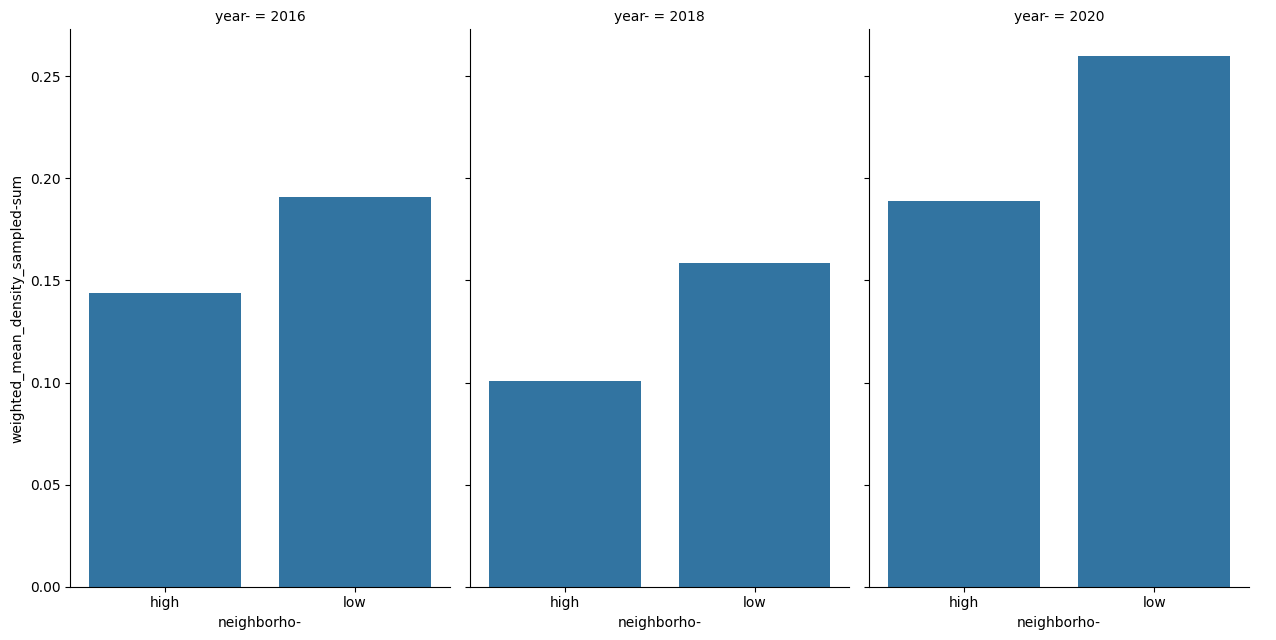

In [7]:
g = sns.FacetGrid(aggregates, col="year-",  height=6.5, aspect=.65)
g.map(sns.barplot, 'neighborho-', 'weighted_mean_density_sampled-sum')
g.add_legend()
plt.show()

## 2. Permitted portion of small building growth
We estimate the following outcome using CF annotations`(highpermit20-highpermit16)/(high20-high16) - (lowpermit20-lowpermit16)/(low20-low16)`

## 2.1 No geospatial mapping
Computes outcome as total permits issued over the total additions of small buildings for both neighborhoods.

[INFO] Number of construction, addition & alteration permits: 14384
[INFO] Number of construction, addition & alteration permits in CF area: 1298
  neighborho  new_sbuilds_16_20  new_permits_16_20  perm_rate
0       high                362               78.0   0.215470
1        low                601              193.0   0.321131


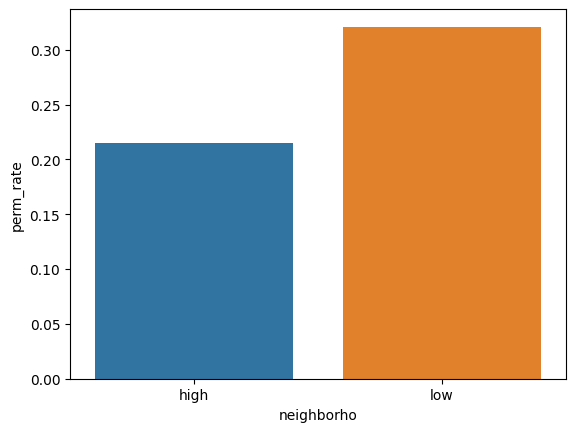

In [8]:
# Compute new small buildings by neighborhoood type in the CF universe of parcels
rate_outcome = parcel_density.groupby(['neighborho', 'year'])['parcel_density'].sum().reset_index()
rate_outcome = rate_outcome.pivot(
    index='neighborho', columns='year', values='parcel_density').reset_index()
rate_outcome['new_sbuilds_16_20'] = rate_outcome['2020'] - rate_outcome['2016']

# Compute new "ADU" permits by neighborhood type
permits_nongeo = gpd.GeoDataFrame(
    data=permits[['OBJECTID_left', 'issue_year', 'geometry_permit']], 
    geometry='geometry_permit', crs='EPSG:4326')
print('[INFO] Number of construction, addition & alteration permits: {}'.format(len(permits_nongeo)))

# * Limit permits to CF area coverage
permits_nongeo = gpd.clip(permits_nongeo, CF_area_coverage)
print('[INFO] Number of construction, addition & alteration permits in CF area: {}'.format(
    len(permits_nongeo)))

# * Assign permits to neighborhoods
n_permits = len(permits_nongeo)
permits_nongeo = permits_nongeo.sjoin(neighborhoods, how='left', predicate='intersects')
assert(len(permits_nongeo) == n_permits)

permits_nongeo['issue_year'] = permits_nongeo['issue_year'].astype(str)

# * Aggregate and compute change in permits
permits_nongeo = permits_nongeo.groupby(
    ['neighborho', 'issue_year'])['OBJECTID_left'].count().reset_index()

permits_nongeo = permits_nongeo.pivot(
    index='neighborho', columns='issue_year', values='OBJECTID_left').reset_index()

permits_nongeo['cumulative_17_20'] = permits_nongeo.apply(
    lambda row: row['2017'] + row['2018'] + row['2019'] + row['2020'], axis=1)

permits_nongeo['new_permits_16_20'] = permits_nongeo['cumulative_17_20'] - permits_nongeo['2016']

# Merge small building and permit data
rate_outcome = pd.merge(
    rate_outcome[['neighborho', 'new_sbuilds_16_20']], permits_nongeo[['neighborho', 'new_permits_16_20']], 
    validate='one_to_one')

rate_outcome['perm_rate'] = rate_outcome['new_permits_16_20'] / rate_outcome['new_sbuilds_16_20']

print(rate_outcome)
sns.barplot(rate_outcome, x='neighborho', y='perm_rate')
plt.show()

## 2.2 Geospatial mapping
Compute permitted and unpermitted small building density at the parcel level as permitted small buildings = min(parcel permits, parcel small build), and unpermitted = total small building in parcel - permitted small buildings

In [18]:
rate_outcome_geo = parcel_density_permitted.copy()

Aggregate by high/low income neighborhood (split at 50th percentile).

  neighborho  permitted_change  unpermitted_change  total_change  perm_rate
0       high              12.0               754.0         766.0   0.015666
1        low              19.0              1064.0        1083.0   0.017544


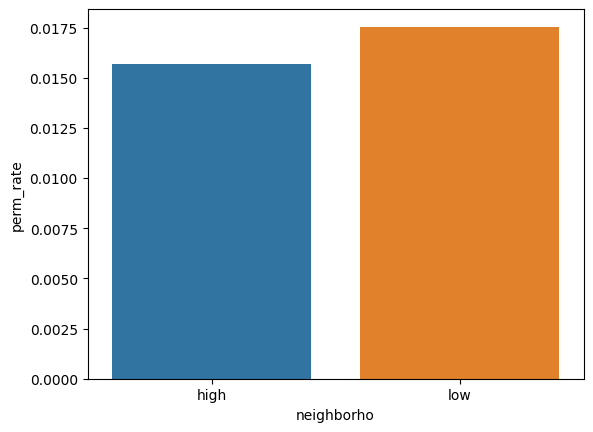

In [19]:
# Aggregate by neighborhood
rate_outcome_geo_agg = rate_outcome_geo.groupby('neighborho')[
    ['permitted_change', 'unpermitted_change']].sum().reset_index()

# Compute permitted change
rate_outcome_geo_agg['total_change'] = rate_outcome_geo_agg['permitted_change'] + rate_outcome_geo_agg['unpermitted_change']
rate_outcome_geo_agg['perm_rate'] = rate_outcome_geo_agg.apply(
    lambda row: row['permitted_change'] / row['total_change'] , 
    axis=1)

print(rate_outcome_geo_agg)
sns.barplot(rate_outcome_geo_agg, x='neighborho', y='perm_rate')
plt.show()

Aggregate by quartiles based on CBG median income.

        quartile  permitted_change  unpermitted_change  total_change  \
0            Low              10.0               612.0         622.0   
1   Low-Moderate               9.0               452.0         461.0   
2  High-moderate               3.0               396.0         399.0   
3           High               9.0               358.0         367.0   

   perm_rate  
0   0.016077  
1   0.019523  
2   0.007519  
3   0.024523  


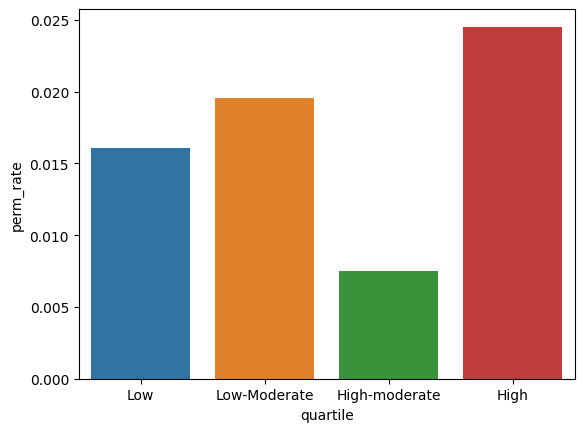

In [21]:
# Generate decile column
cbg_income_2016_SJ['quartile'] = pd.qcut(
    cbg_income_2016_SJ['median_inc'], q=4, 
    labels=['IS_{}'.format(i) for i in range(4)])

# Disaggregate further (by quartile)
# * Add income strata data
rate_outcome_geo_disag = rate_outcome_geo.copy()
rate_outcome_geo_disag = pd.merge(
    rate_outcome_geo_disag, cbg_income_2016_SJ[['GEOID', 'quartile', 'strata_inc']], 
    how='left', validate='many_to_one')

quartile_neighborhoods = {'IS_0': 'Low', 'IS_1': 'Low', 'IS_2': 'Low', 'IS_3': 'High'}
rate_outcome_geo_disag['neighborhood'] = rate_outcome_geo_disag['quartile'].apply(
    lambda quartile: quartile_neighborhoods[quartile])

quartile_names = {'IS_0': 'Low', 'IS_1': 'Low-Moderate', 'IS_2': 'High-moderate', 'IS_3': 'High'}
rate_outcome_geo_disag['quartile'] = rate_outcome_geo_disag['quartile'].apply(
    lambda quartile: quartile_names[quartile])

# Aggregate by neighborhood
rate_outcome_geo_disag_neigh = rate_outcome_geo_disag.groupby(['neighborhood'])[
    ['permitted_change', 'unpermitted_change']].sum().reset_index()
#rate_outcome_geo_disag_neigh = rate_outcome_geo_disag.copy()

rate_outcome_geo_disag_neigh['total_change'] = rate_outcome_geo_disag_neigh[
    'permitted_change'] + rate_outcome_geo_disag_neigh['unpermitted_change']
rate_outcome_geo_disag_neigh['perm_rate'] = rate_outcome_geo_disag_neigh.apply(
    lambda row: None if row['total_change']==0 else row['permitted_change'] / row['total_change'] , 
    axis=1)

# Aggregate by quartile
rate_outcome_geo_disag = rate_outcome_geo_disag.groupby('quartile')[
    ['permitted_change', 'unpermitted_change']].sum().reset_index()

rate_outcome_geo_disag['total_change'] = rate_outcome_geo_disag[
    'permitted_change'] + rate_outcome_geo_disag['unpermitted_change']
rate_outcome_geo_disag['perm_rate'] = rate_outcome_geo_disag.apply(
    lambda row: row['permitted_change'] / row['total_change'] , 
    axis=1)

print(rate_outcome_geo_disag)
sns.barplot(rate_outcome_geo_disag, x='quartile', y='perm_rate')
plt.show()

In [35]:
rate_outcome_geo_disag

,quartile,permitted_change,unpermitted_change,total_change,perm_rate
0,Low,10.0,612.0,622.0,0.016077
1,Low-Moderate,9.0,452.0,461.0,0.019523
2,High-moderate,3.0,396.0,399.0,0.007519
3,High,9.0,358.0,367.0,0.024523


Base-level of permitting vs unpermitting

In [37]:
permitting_levels = rate_outcome_geo.copy()
permitting_levels = pd.merge(
    permitting_levels, cbg_income_2016_SJ[['GEOID', 'quartile']], 
    how='left', validate='many_to_one')

In [38]:
permitting_levels_quart = permitting_levels.groupby('quartile')[[
    'permitted_sb_2016', 'permitted_sb_2020', 'unpermitted_sb_2016',
    'unpermitted_sb_2020']].sum().reset_index()
for year in ['2016', '2020']:
    permitting_levels_quart['prop_{}'.format(year)] = permitting_levels_quart.apply(
        lambda row: row['permitted_sb_{}'.format(year)] / (
            row['permitted_sb_{}'.format(year)] + row['unpermitted_sb_{}'.format(year)]), 
        axis=1)
permitting_levels_quart

,quartile,permitted_sb_2016,permitted_sb_2020,unpermitted_sb_2016,unpermitted_sb_2020,prop_2016,prop_2020
0,IS_0,26.0,36.0,784.0,1396.0,0.032099,0.025140
1,IS_1,37.0,46.0,817.0,1269.0,0.043326,0.034981
2,IS_2,21.0,24.0,429.0,825.0,0.046667,0.028269
3,IS_3,32.0,41.0,679.0,1037.0,0.045007,0.038033


In [26]:
permitting_levels_quart = pd.melt(
    permitting_levels_quart, id_vars='quartile', value_vars=['prop_2016', 'prop_2020'], 
    var_name='prop_year')
permitting_levels_quart['year'] = permitting_levels_quart['prop_year'].str.replace('prop_', '')

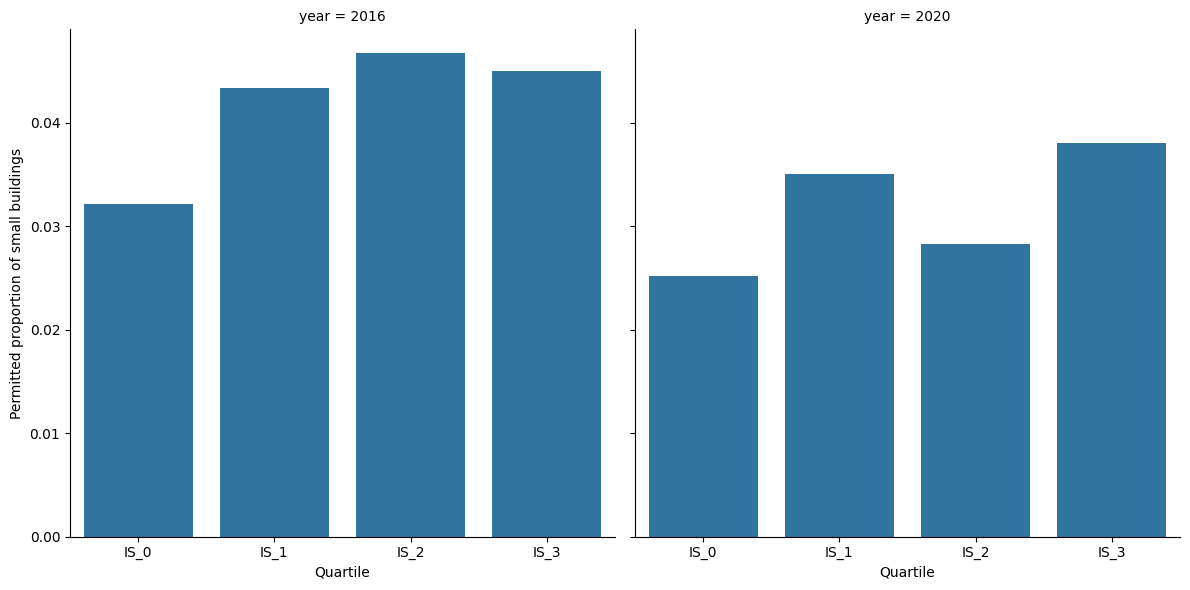

In [27]:
g = sns.FacetGrid(permitting_levels_quart, col='year', height=6, aspect=1)
g = g.map_dataframe(sns.barplot, x="quartile", y='value')
g.set_axis_labels("Quartile")
g.set_ylabels('Permitted proportion of small buildings')
plt.show()

### 2.3 Geospatial mapping (new small buildings)
Directly match CF dots at the building-level to identify new buildings; still use parcel-level matching to permits to classify new small buildings as permitted vs unpermitted. 

In [31]:
rate_outcome_geo_mapped = parcel_growth_permitted.copy()

In [32]:
# Generate decile column
cbg_income_2016_SJ['quartile'] = pd.qcut(
    cbg_income_2016_SJ['median_inc'], q=4, 
    labels=['IS_{}'.format(i) for i in range(4)])

# Disaggregate by quartile
# * Add income strata data
rate_outcome_geo_mapped_disag = rate_outcome_geo_mapped.copy()
rate_outcome_geo_mapped_disag = pd.merge(
    rate_outcome_geo_mapped_disag, cbg_income_2016_SJ[['GEOID', 'quartile', 'strata_inc']], 
    how='left', validate='many_to_one')

quartile_neighborhoods = {'IS_0': 'Low', 'IS_1': 'Low', 'IS_2': 'Low', 'IS_3': 'High'}
rate_outcome_geo_mapped_disag['neighborhood'] = rate_outcome_geo_mapped_disag['quartile'].apply(
    lambda quartile: quartile_neighborhoods[quartile])

quartile_names = {'IS_0': 'Low', 'IS_1': 'Low-Moderate', 'IS_2': 'High-moderate', 'IS_3': 'High'}
rate_outcome_geo_mapped_disag['quartile'] = rate_outcome_geo_mapped_disag['quartile'].apply(
    lambda quartile: quartile_names[quartile])

In [33]:
rate_outcome_geo_mapped_disag.head()

,Unnamed: 0,APN,new_small_build,2015_20,permitted_change,unpermitted_change,GEOID,quartile,strata_inc,neighborhood
0,0,70616068,0,0.0,0.0,0.0,060855120352,High-moderate,IS_35,Low
1,1,23032111,0,0.0,0.0,0.0,060855051001,Low,IS_12,Low
2,2,43948043,0,0.0,0.0,0.0,060855030021,High-moderate,IS_29,Low
3,3,43941077,0,0.0,0.0,0.0,060855030022,High,IS_39,High
4,4,42132050,0,0.0,0.0,0.0,060855027024,High-moderate,IS_35,Low


At the neighborhood level (75 percentile)
  neighborhood  permitted_change  unpermitted_change  total_change  perm_rate
0         High              11.0               399.0         410.0   0.026829
1          Low              27.0              1593.0        1620.0   0.016667


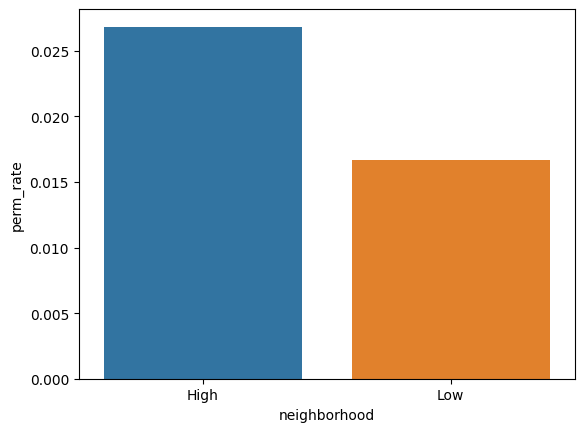

At the quartile level
        quartile  permitted_change  unpermitted_change  total_change  \
0            Low              11.0               662.0         673.0   
1   Low-Moderate              12.0               502.0         514.0   
2  High-moderate               4.0               429.0         433.0   
3           High              11.0               399.0         410.0   

   perm_rate  
0   0.016345  
1   0.023346  
2   0.009238  
3   0.026829  


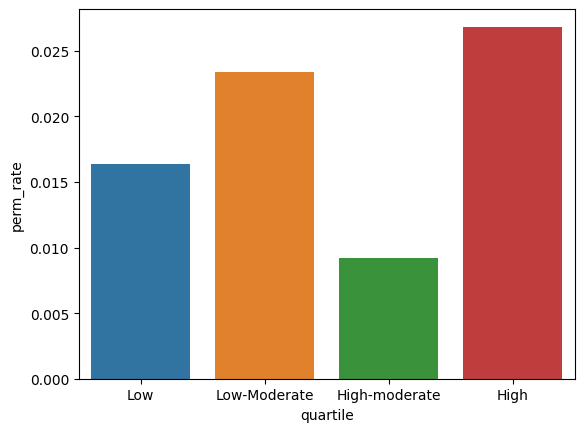

In [34]:
# Aggregate by neighborhood
rate_outcome_geo_mapped_disag_neigh = rate_outcome_geo_mapped_disag.groupby(['neighborhood'])[
    ['permitted_change', 'unpermitted_change']].sum().reset_index()

rate_outcome_geo_mapped_disag_neigh['total_change'] = rate_outcome_geo_mapped_disag_neigh[
    'permitted_change'] + rate_outcome_geo_mapped_disag_neigh['unpermitted_change']
rate_outcome_geo_mapped_disag_neigh['perm_rate'] = rate_outcome_geo_mapped_disag_neigh.apply(
    lambda row: None if row['total_change']==0 else row['permitted_change'] / row['total_change'] , 
    axis=1)

print('At the neighborhood level (75 percentile)')
print(rate_outcome_geo_mapped_disag_neigh)
sns.barplot(rate_outcome_geo_mapped_disag_neigh, x='neighborhood', y='perm_rate')
plt.show()

# Aggregate by quartile
rate_outcome_geo_mapped_disag = rate_outcome_geo_mapped_disag.groupby('quartile')[
    ['permitted_change', 'unpermitted_change']].sum().reset_index()

rate_outcome_geo_mapped_disag['total_change'] = rate_outcome_geo_mapped_disag[
    'permitted_change'] + rate_outcome_geo_mapped_disag['unpermitted_change']
rate_outcome_geo_mapped_disag['perm_rate'] = rate_outcome_geo_mapped_disag.apply(
    lambda row: row['permitted_change'] / row['total_change'] , 
    axis=1)

print('At the quartile level')
print(rate_outcome_geo_mapped_disag)
sns.barplot(rate_outcome_geo_mapped_disag, x='quartile', y='perm_rate')
plt.show()

### 2.4 Nearest permit assignment 
Assign permits to the closest small building (within a threshold)

In [31]:
rate_outcome_nearest = parcel_growth_permitted_snap.copy()

In [32]:
# Generate decile column
cbg_income_2016_SJ['quartile'] = pd.qcut(
    cbg_income_2016_SJ['median_inc'], q=4, 
    labels=['IS_{}'.format(i) for i in range(4)])

# Disaggregate by quartile
# * Add income strata data
rate_outcome_nearest_disag = rate_outcome_nearest.copy()
rate_outcome_nearest_disag = pd.merge(
    rate_outcome_nearest_disag, cbg_income_2016_SJ[['GEOID', 'quartile', 'strata_inc']], 
    how='left', validate='many_to_one')

quartile_neighborhoods = {'IS_0': 'Low', 'IS_1': 'Low', 'IS_2': 'Low', 'IS_3': 'High'}
rate_outcome_nearest_disag['neighborhood'] = rate_outcome_nearest_disag['quartile'].apply(
    lambda quartile: quartile_neighborhoods[quartile])

quartile_names = {'IS_0': 'Low', 'IS_1': 'Low-Moderate', 'IS_2': 'High-moderate', 'IS_3': 'High'}
rate_outcome_nearest_disag['quartile'] = rate_outcome_nearest_disag['quartile'].apply(
    lambda quartile: quartile_names[quartile])

At the quartile level
        quartile  permitted_change  unpermitted_change  total_change  \
0            Low              87.0               626.0         713.0   
1   Low-Moderate              85.0               459.0         544.0   
2  High-moderate              98.0               357.0         455.0   
3           High             106.0               345.0         451.0   

   perm_rate  
0   0.122020  
1   0.156250  
2   0.215385  
3   0.235033  


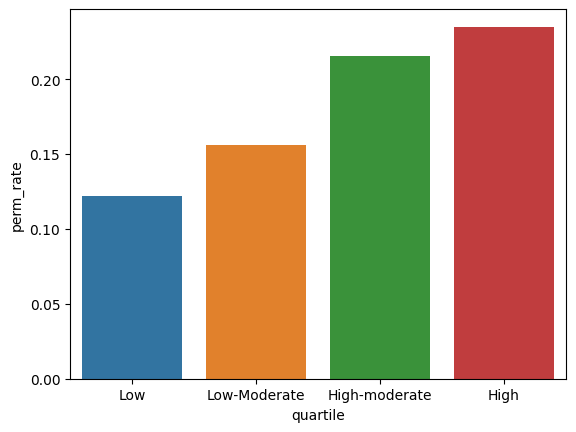

In [33]:
# Aggregate by quartile
rate_outcome_nearest_disag = rate_outcome_nearest_disag.groupby('quartile')[
    ['permitted_change', 'unpermitted_change']].sum().reset_index()

rate_outcome_nearest_disag['total_change'] = rate_outcome_nearest_disag[
    'permitted_change'] + rate_outcome_nearest_disag['unpermitted_change']
rate_outcome_nearest_disag['perm_rate'] = rate_outcome_nearest_disag.apply(
    lambda row: row['permitted_change'] / row['total_change'] , 
    axis=1)

print('At the quartile level')
print(rate_outcome_nearest_disag)
sns.barplot(rate_outcome_nearest_disag, x='quartile', y='perm_rate')
plt.show()

## Explore the drop in permits


In [26]:
a = rate_outcome_geo.loc[rate_outcome_geo['permitted_change'] > 0]

In [27]:
b = rate_outcome_geo_mapped.loc[rate_outcome_geo_mapped['permitted_change'] > 0]

In [29]:
missing_pbuilds = a.loc[~a['APN'].isin(b['APN'])]

In [30]:
missing_pbuilds

,APN,GEOID,neighborho,permitted_sb-2016,permitted_sb-2020,unpermitted_sb-2016,unpermitted_sb-2020,permitted_change,unpermitted_change
325,23510046,060855001001,low,0.0,1.0,0.0,0.0,1.0,0.0
754,24915056,060855001003,low,0.0,1.0,1.0,0.0,1.0,0.0
885,24925021,060855011021,high,0.0,1.0,0.0,0.0,1.0,0.0
1097,24940033,060855002003,low,0.0,1.0,0.0,0.0,1.0,0.0
1176,24943015,060855002003,low,0.0,1.0,1.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...
13613,64701006,060855035081,low,0.0,1.0,0.0,0.0,1.0,0.0
13649,64702013,060855035081,low,0.0,1.0,0.0,0.0,1.0,0.0
14251,65422082,060855033123,low,0.0,1.0,1.0,0.0,1.0,0.0
16052,70154019,060855119123,high,0.0,1.0,0.0,0.0,1.0,0.0


Permitted change for computation 1 is positive but correctly 0 for computation 2. 

In [41]:
rate_outcome_geo.loc[rate_outcome_geo['APN'] == '23510046']

,APN,GEOID,neighborho,permitted_sb-2016,permitted_sb-2020,unpermitted_sb-2016,unpermitted_sb-2020,permitted_change,unpermitted_change
325,23510046,060855001001,low,0.0,1.0,0.0,0.0,1.0,0.0


In [31]:
rate_outcome_geo_mapped.loc[rate_outcome_geo_mapped['APN'] == '23510046']

,APN,new_small_build,2016_20,permitted_change,unpermitted_change,GEOID
9830,23510046,1,0.0,0.0,1.0,060855001001


In [33]:
parcel_permits.loc[parcel_permits['APN'] == '23510046']

issue_year,APN,<=2016,<=2020,2016_20
329,23510046,1.0,1.0,0.0


In [36]:
permits.loc[permits['APN_parcel'] == '23510046']

,OBJECTID_left,FACILITYID,INTID_left,ADDRESS,APN,APPLICANT,CONTRACTOR,WORKDESC,SUBDESC,PERMITAPPROVAL,...,PLANMOD,LASTUPDATE_right,NOTES_right,COVERED,SHAPE_Length,SHAPE_Area,geometry_parcel,issue_date_converted,foldernum_year,issue_year
7663,E_16903,16873,16873,"922 N 5TH ST , SAN JOSE CA 95112-4411",23510046,CHARLES WINDOW AND DOOR CO.,CHARLES WINDOW AND DOOR CO.,Additions/Alterations,Single-Family,B-Complete,...,NaN,2005-10-25T12:21:45+00:00,NaN,NaN,378.444839,6934.705151,POLYGON ((-121.8991290828552 37.35637352207403...,2011-08-18 00:00:00,2011,2011


In [40]:
permits.head()

,OBJECTID_left,FACILITYID,INTID_left,ADDRESS,APN,APPLICANT,CONTRACTOR,WORKDESC,SUBDESC,PERMITAPPROVAL,...,PLANMOD,LASTUPDATE_right,NOTES_right,COVERED,SHAPE_Length,SHAPE_Area,geometry_parcel,issue_date_converted,foldernum_year,issue_year
0,A_294,351,351,"2027 LOCKWOOD DR , SAN JOSE CA 95132-1323",09226077,CHRISTOPHER CAO,NaN,New Construction,2nd Unit Added,"B-Complete, E-Complete, M-Complete, P-Complete",...,NaN,2005-10-25T12:21:45+00:00,NaN,NaN,326.012722,6135.963876,POLYGON ((-121.86054155726158 37.4153855051544...,2019-02-20 00:00:00,2018,2019
1,A_774,837,837,"2238 BELTHORN CT , SAN JOSE CA 95131-2804",24506056,NONE,NaN,Additions/Alterations,Single-Family,NaN,...,NaN,2005-10-25T12:21:45+00:00,NaN,NaN,336.977450,6236.070440,POLYGON ((-121.86573756372348 37.3844855056577...,2016-10-27 00:00:00,2015,2016
2,A_847,973,973,"2693 OLIVESTONE WY , SAN JOSE CA 95132-2544",24502027,CORTEZ CLAUDIA NAVARRO ET AL,NaN,Additions/Alterations,Single-Family,"B-Complete, E-Complete, M-Complete, P-Complete",...,NaN,2005-10-25T12:21:45+00:00,NaN,NaN,333.429779,7091.648282,POLYGON ((-121.86854248700051 37.3939474142558...,2019-06-04 00:00:00,2019,2019
3,A_851,22817,22817,"2001 FORTUNE DR 2 , SAN JOSE CA 95131",24417003,"HOLDER CONSTRUCTION GROUP, LLC TIMOTHY BELL","HOLDER CONSTRUCTION GROUP, LLC",New Construction,Data Center,"B-4. Complete, E-4. Complete, P-4. Complete, M...",...,APNU_20180201,2018-12-20T00:04:03+00:00,NaN,NaN,2670.795089,393543.761702,POLYGON ((-121.8922620796795 37.40331423260569...,2020-07-20 00:00:00,2020,2020
4,A_1106,26942,26942,"525 N 7TH ST , SAN JOSE CA 95112",24938042,ZWICK CONSTRUCTION COMPANY,ZWICK CONSTRUCTION COMPANY,New Construction,Apt/Condo/Townhouse,"B-4. Complete, E-4. Complete, P-4. Complete, M...",...,3-05766,2019-08-20T18:20:20+00:00,NaN,NaN,1385.208842,55642.667605,POLYGON ((-121.89180016808963 37.3491906874904...,2019-07-12 00:00:00,2018,2019


In [6]:
# Permits matching to CF parcels
permits_CF_parcels = permits.loc[permits['APN_parcel'].isin(parcel_growth['APN'].unique())]

In [8]:
# Permits matching to CF area coverage
permits_CF_area = gpd.GeoDataFrame(
    permits[['APN_parcel', 'issue_year', 'geometry_permit']], geometry='geometry_permit')
permits_CF_area = gpd.clip(permits_CF_area, CF_area_coverage)

In [9]:
print(len(permits_CF_parcels))
print(len(permits_CF_area))

1066
1298


In [10]:
# Subset to permits issued 2016-2020
permits_CF_parcels = permits_CF_parcels.loc[
    permits_CF_parcels['issue_year'].isin([2016, 2017, 2018, 2019, 2020])]

permits_CF_area = permits_CF_area.loc[
    permits_CF_area['issue_year'].isin([2016, 2017, 2018, 2019, 2020])]

In [11]:
print(len(permits_CF_parcels))
print(len(permits_CF_area))

247
361


In [69]:
parcel_growth_gdf = pd.merge(parcel_growth, sj_parcels_cbgs[['APN', 'geometry']])
parcel_growth_gdf = gpd.GeoDataFrame(parcel_growth_gdf)

In [96]:
len(CF_area_coverage)

212

In [113]:
x = parcel_growth_gdf.loc[parcel_growth_gdf['new_small_build'] > 0].sjoin(permits_CF_area, how='left')
x = x.loc[~x['index_right'].isna()]

In [114]:
len(x['APN'].unique())

25

In [115]:
len(x)

26

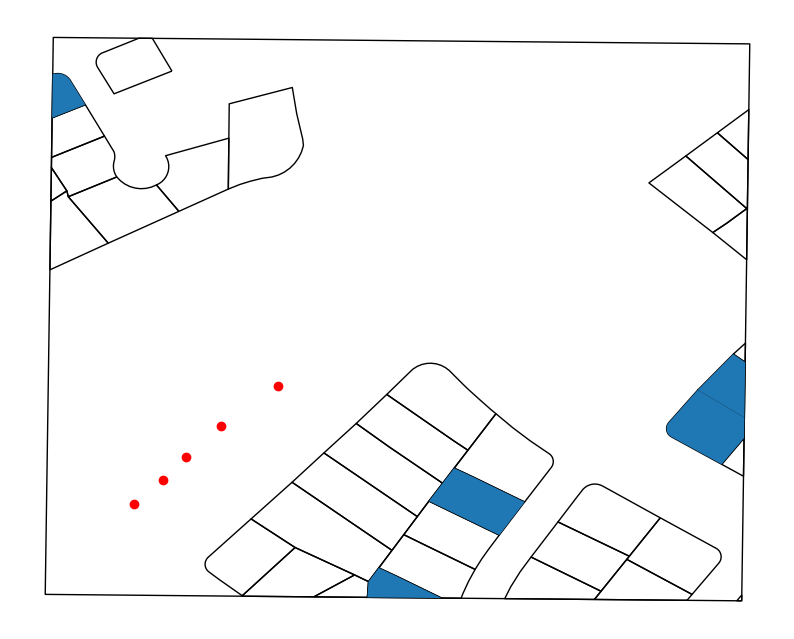

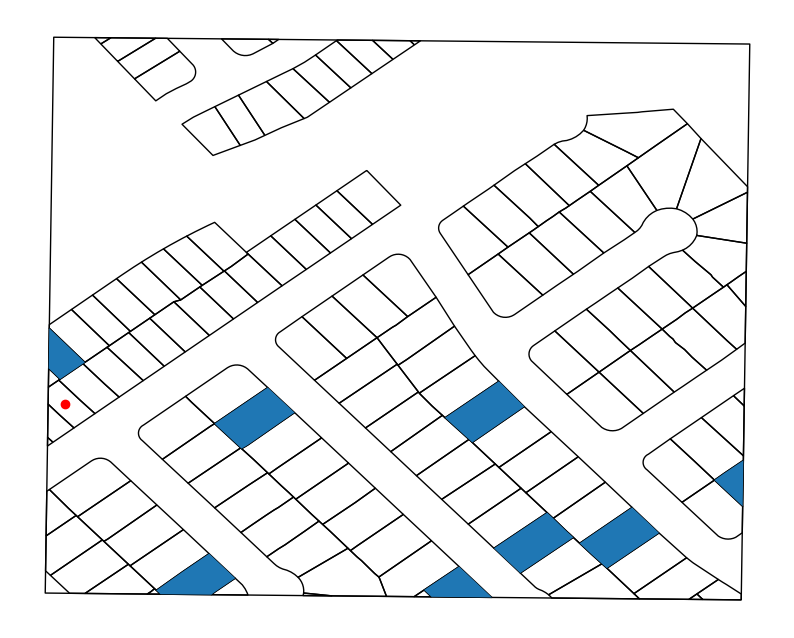

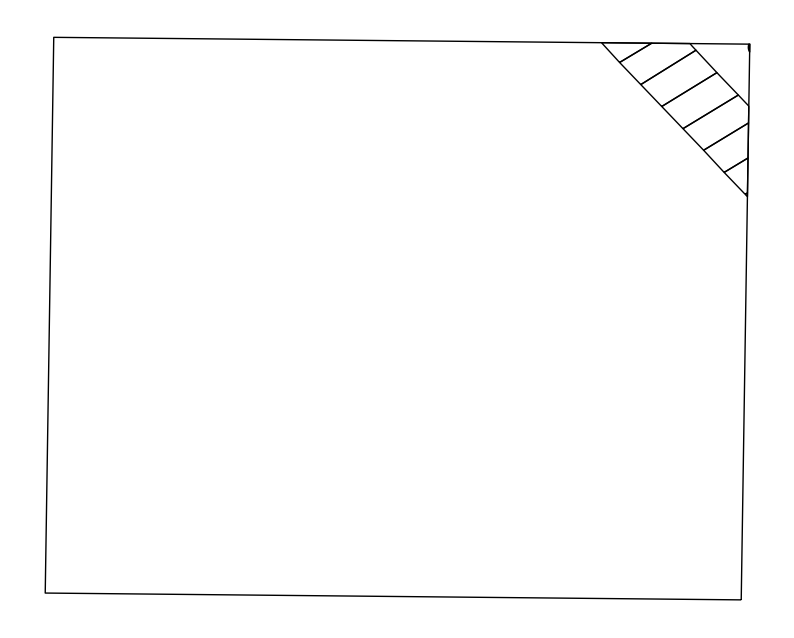

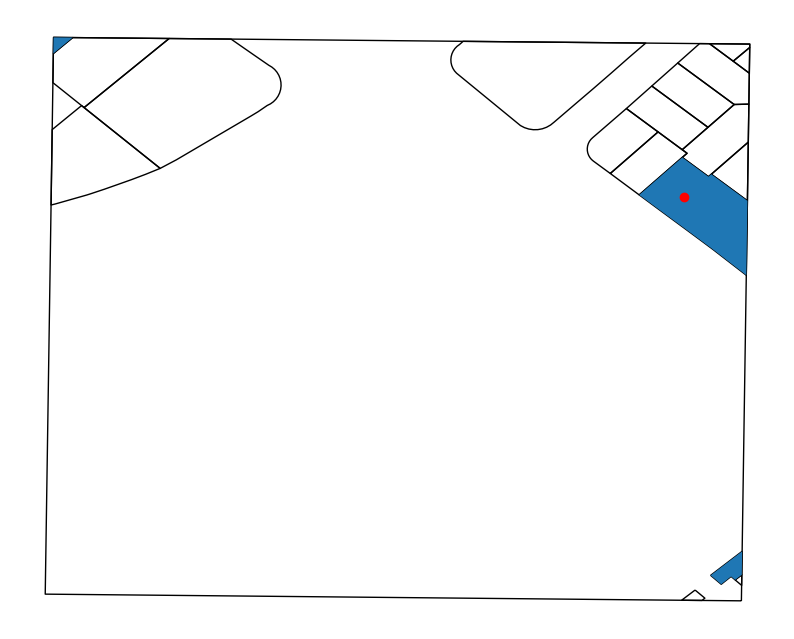

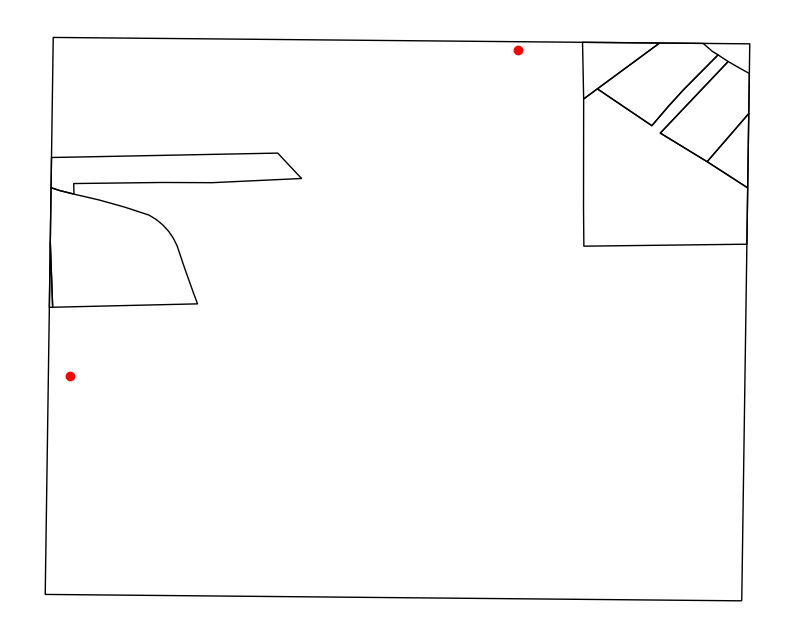

In [119]:
for i in np.random.choice(range(212), size=5):
    tile = CF_area_coverage.iloc[[i]]
    fig, ax = plt.subplots(figsize=(10, 10))
    tile.plot(ax=ax, facecolor='none')
    gpd.clip(parcel_growth_gdf, tile).plot(ax=ax, facecolor='none')
    gpd.clip(parcel_growth_gdf.loc[parcel_growth_gdf['new_small_build'] > 0], tile).plot(ax=ax)
    gpd.clip(permits_CF_area, tile).plot(ax=ax, color='red', )
    ax.axis('off')
    plt.show()

In [12]:
# This is the set of 31 permits we see
len(set(permits_CF_parcels['APN_parcel'].unique()).intersection(set(
    parcel_growth.loc[parcel_growth['new_small_build'] > 0]['APN'].unique()
)))

31

## 3. Small building growth distribution

In [37]:
sb_growth = parcel_density.copy()
sb_growth = sb_growth.loc[sb_growth['year'] != '2018']

sb_growth = sb_growth.pivot(
    index=['APN', 'GEOID'], columns='year', values='parcel_density').reset_index()

sb_growth['num_new_sbs'] = sb_growth.apply(
    lambda row: max(0, row['2020'] - row['2016']), axis=1)

# Add neighborhood
high_income_cbgs = cbg_income_2016_SJ.loc[cbg_income_2016_SJ['quartile'] == 'IS_3']['GEOID'].unique()
print('Number of high income CBGS (defined by 75%): {}'.format(len(high_income_cbgs)))

sb_growth['neighborhood'] = sb_growth['GEOID'].apply(
    lambda geoid: 'high' if geoid in high_income_cbgs else 'low')

sb_growth.groupby(['neighborhood', 'num_new_sbs'])['APN'].count().reset_index()

Number of high income CBGS (defined by 75%): 160


,neighborhood,num_new_sbs,APN
0,high,0,3319
1,high,1,314
2,high,2,22
3,high,3,3
4,low,0,11768
5,low,1,1225
6,low,2,110
7,low,3,7
8,low,4,2
9,low,8,1


Note: Can use parcel_density and parcel_growth, consistent numbers

In [51]:
parcel_density_permitted['permitted_change'].sum() + parcel_density_permitted['unpermitted_change'].sum()

1849.0

In [52]:
parcel_growth_permitted['new_small_build'].sum()

2030

In [53]:
parcel_density_permitted['permitted_change'].sum()

31.0

In [54]:
parcel_growth_permitted['permitted_change'].sum()

38.0